In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from datetime import datetime

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope

import scipy
from scipy import stats
from scipy.stats import gamma, lognorm

from patsy import dmatrices

import statsmodels.api as sm
from statsmodels.formula.api import glm
from statsmodels.graphics.api import abline_plot

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


In [2]:
# loading data
df_att = pd.read_feather('data/rca_autoturisme_atribute.feather')

# not all attributes are needed for the current modeling
# KMPG attributes used are only the engine cylindrical capacity and client age
df_att.drop(['clasaBM', 'tipVehicul', 'marca','putere',
       'locuri', 'anFabricatie', 'masaTehnica', 'tip','judet',
       'localitate', 'sex'], axis = 1, inplace = True)
df_att.rename(columns = {'id': 'idPolita'},inplace=True)
df_att.head()

,idPolita,capacitate,varsta
0,2230446,1389,25.0
1,2230447,1781,26.0
2,2230448,1598,62.0
3,2230449,1596,26.0
4,2230450,1390,40.0


In [3]:
# check for nans
df_att.isnull().sum()

idPolita        0
capacitate      0
varsta        487
dtype: int64

In [4]:
df_att.varsta.median()

46.0

There are ~500 missing age values. Will replace them with the median age.

In [5]:
df_att.varsta.fillna(df_att.varsta.median(), inplace = True)
df_att.isnull().sum()

idPolita      0
capacitate    0
varsta        0
dtype: int64

In [6]:
# check for duplicates
df_att.duplicated().sum()

0

In [7]:
df_att.describe().T

,count,mean,std,min,25%,50%,75%,max
idPolita,19706726.0,2.981157e+07,5.232621e+07,2230446.0,8336687.25,14898078.0,22711748.5,203964267.0
capacitate,19706726.0,1.747341e+03,4.318539e+02,0.0,1461.00,1716.0,1968.0,12902.0
varsta,19706726.0,4.715306e+01,1.427444e+01,-29.0,36.00,46.0,58.0,118.0


Cylindrical capacity has zero values. Age has negative values.

### Cylindrical capacity analysis

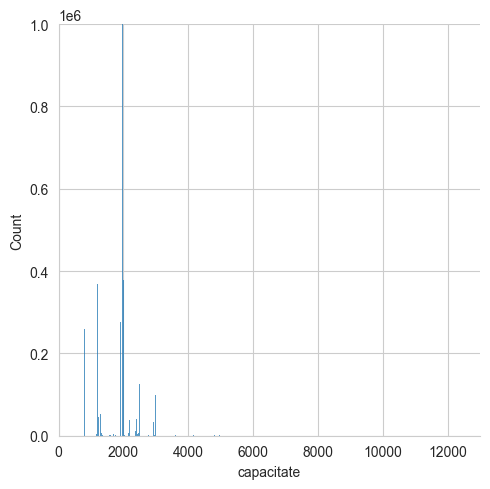

In [8]:
fig = sns.displot(data = df_att, x = 'capacitate');
fig.set(xlim = (0, 13000))
fig.set(ylim = (0, 1000000))


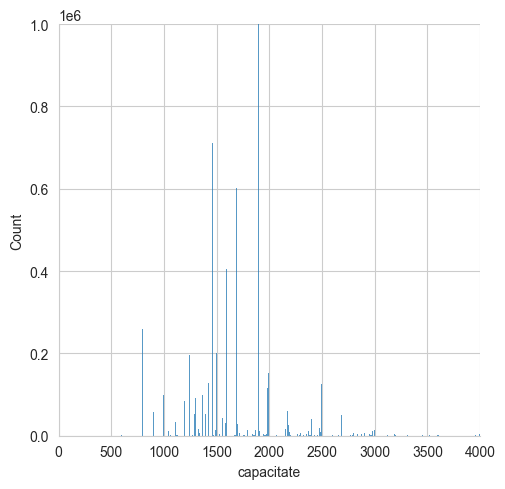

In [9]:
fig = sns.displot(data = df_att, x = 'capacitate');
fig.set(xlim = (0, 4000))
fig.set(ylim = (0, 1000000))


In [10]:
# percentage of cars with capacities under 500, which would be suspicious
print(f'Percentage of cars with under 500 cylindrical capacity: {"{:.2f}".format((df_att[df_att.capacitate < 500].shape[0]/df_att.shape[0])*100)}')

Percentage of cars with under 500 cylindrical capacity: 0.01


In [11]:
# create list of their indices for future removal
list_small_capacity = df_att[df_att.capacitate < 500].index

In [13]:
# delete the above selected rows
df_att.drop(list_small_capacity, axis = 0, inplace = True)
df_att.reset_index(drop=True, inplace = True)

The capacity values must be binned into several categories, as per the KPMG report.

In [17]:
# binning operation
bins = [0, 1200, 1400, 1600, 1800, 2000, 2500, np.inf]
labels = ['c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7']
df_att['cap_ctg'] = pd.cut(df_att['capacitate'], bins=bins, labels=labels)

df_att.sample(15)

,idPolita,capacitate,varsta,cap_ctg
3682124,6778391,2143,59.0,c6
14220768,21768693,1896,68.0,c5
17727840,27144559,1896,46.0,c5
11607055,17604148,1956,26.0,c5
1986628,4577772,1248,45.0,c2
15901952,24451410,1598,35.0,c3
15052104,23156609,1896,79.0,c5
410629,2662472,1598,36.0,c3
5395537,8921144,2987,56.0,c7
3457968,6479649,1598,60.0,c3


In [18]:
df_att.drop('capacitate', axis = 1, inplace = True)

### Age analysis

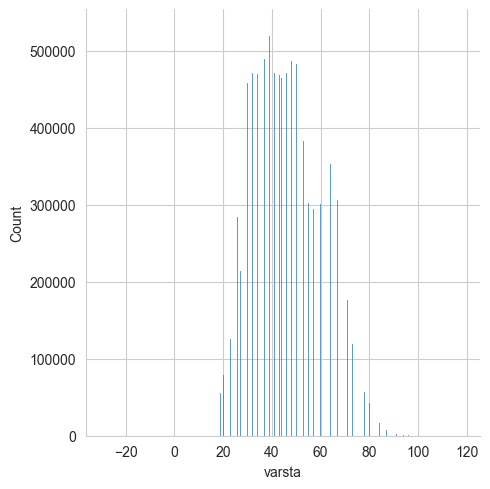

In [12]:
fig = sns.displot(data = df_att, x = 'varsta');

Age apears to be almost normally distributed.

In [19]:
# percentage of drivers under 18 - one cannot be insured under the age of 18, 
# meaning that such values are incorrect
print(f'Percentage of drivers under 18 years of age: {"{:.3f}".format((df_att[df_att.varsta < 18].shape[0]/df_att.shape[0])*100)}')

Percentage of drivers under 18 years of age: 0.007


In [20]:
# create list of their indices for future removal
list_incorrect_age = df_att[df_att.varsta < 18].index

In [21]:
# delete the above selected rows
df_att.drop(list_incorrect_age, axis = 0, inplace = True)
df_att.reset_index(drop=True, inplace = True)

The age values must be binned into several categories, as per the KPMG report.

In [22]:
# binning operation
bins = [0, 30, 40, 50, 60, np.inf]
labels = ['a1', 'a2', 'a3', 'a4', 'a5']
df_att['age_ctg'] = pd.cut(df_att['varsta'], bins=bins, labels=labels)

df_att.sample(15)

,idPolita,varsta,cap_ctg,age_ctg
3564883,6622799,32.0,c4,a2
14086984,21557979,28.0,c6,a1
4861414,8255319,37.0,c4,a2
7206929,11287991,23.0,c2,a1
11153357,16904197,32.0,c5,a2
10811517,16372643,74.0,c2,a5
1939546,4512191,58.0,c3,a4
14186744,21716562,62.0,c3,a5
4911899,8318650,39.0,c6,a2
896752,3185038,64.0,c5,a5


In [23]:
df_att.drop('varsta', axis = 1, inplace = True)

In [25]:
# save data
df_att.to_feather('data/input_autoturisme_attributes.feather')

### Check claim values dataframes

In [26]:
claims_mat = pd.read_feather('data/rca_autoturisme_valEvMat.feather')
claims_vat = pd.read_feather('data/rca_autoturisme_valEvVat.feather')

#### Material damages

In [27]:
claims_mat.duplicated().sum()

0

In [28]:
claims_mat.isnull().sum()

idEvent      0
acc_year     0
idPolita     0
plati_ron    0
plati_eur    0
res_ron      0
res_eur      0
val_ron      0
val_eur      0
tip          0
dtype: int64

In [29]:
claims_mat.describe().T

,count,mean,std,min,25%,50%,75%,max
idEvent,428237.0,2.932371e+05,1.868726e+05,0.000000e+00,1.291670e+05,2.807690e+05,4.569200e+05,6.280170e+05
acc_year,428237.0,2.018534e+03,1.725462e+00,2.015000e+03,2.017000e+03,2.019000e+03,2.020000e+03,2.021000e+03
idPolita,428237.0,1.783828e+07,2.984997e+07,2.230466e+06,6.629043e+06,1.306497e+07,2.041902e+07,2.038623e+08
plati_ron,428237.0,5.926910e+03,1.887464e+04,0.000000e+00,1.283000e+03,3.027000e+03,6.638000e+03,8.293199e+06
plati_eur,428237.0,1.250959e+03,3.993554e+03,0.000000e+00,2.729659e+02,6.449446e+02,1.403395e+03,1.766892e+06
res_ron,428237.0,1.353833e+03,6.964574e+03,-1.434399e+02,0.000000e+00,0.000000e+00,0.000000e+00,9.550200e+05
res_eur,428237.0,2.778337e+02,1.432820e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.971140e+05
val_ron,428237.0,7.280744e+03,2.065912e+04,-1.000000e+00,1.787764e+03,3.686000e+03,7.719000e+03,8.293199e+06
val_eur,428237.0,1.528792e+03,4.351404e+03,0.000000e+00,3.779371e+02,7.778316e+02,1.624856e+03,1.766892e+06


In [58]:
# check for 0 values in val_ron (the only column to be used in the modeling)
claims_mat[claims_mat.val_ron == 0]

,idEvent,acc_year,idPolita,plati_ron,plati_eur,res_ron,res_eur,val_ron,val_eur,tip
2,2,2015,2230529,0.0,0.0,0.0,0.0,0.0,0.0,MAT
5,5,2015,2230594,0.0,0.0,0.0,0.0,0.0,0.0,MAT
14,18,2015,2230829,0.0,0.0,0.0,0.0,0.0,0.0,MAT
18,22,2015,2230950,0.0,0.0,0.0,0.0,0.0,0.0,MAT
72,78,2015,2232315,0.0,0.0,0.0,0.0,0.0,0.0,MAT
...,...,...,...,...,...,...,...,...,...,...
427236,626491,2021,203215910,0.0,0.0,0.0,0.0,0.0,0.0,MAT
427329,626628,2021,203250610,0.0,0.0,0.0,0.0,0.0,0.0,MAT
427375,626696,2021,203262771,0.0,0.0,0.0,0.0,0.0,0.0,MAT
427720,627213,2021,203399435,0.0,0.0,0.0,0.0,0.0,0.0,MAT


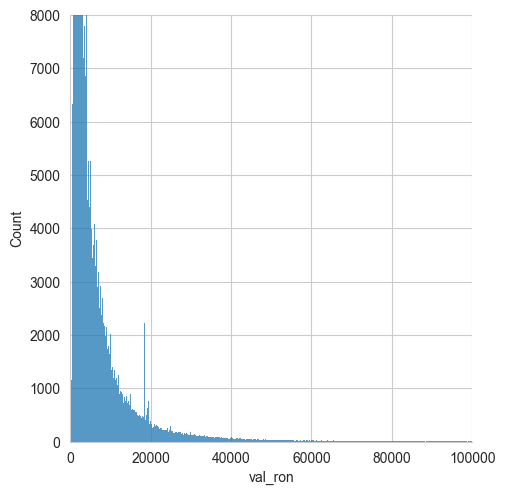

In [59]:
fig = sns.displot(claims_mat, x = 'val_ron');
fig.set(xlim = (0, 100000))
fig.set(ylim = (0, 8000))

The distribution ressembles an exponential one. Therefore, I use the median to replace the 0 values in val_ron (claim value).

In [30]:
claims_mat.val_ron.median()

3686.0

In [31]:
# replace 0 values with the column median
claims_mat.val_ron.replace(0, claims_mat.val_ron.median(), inplace = True)

In [32]:
claims_mat.to_feather('data/rca_autoturisme_valEvMat.feather')

#### Bodily harm (vatamari corporale)

In [62]:
claims_vat.duplicated().sum()

0

In [63]:
claims_vat.isnull().sum()

idEvent      0
acc_year     0
idPolita     0
plati_ron    0
plati_eur    0
res_ron      0
res_eur      0
val_ron      0
val_eur      0
tip          0
dtype: int64

In [64]:
# check for 0 values in val_ron (the only column to be used in the modeling)
claims_vat[claims_vat.val_ron == 0]

,idEvent,acc_year,idPolita,plati_ron,plati_eur,res_ron,res_eur,val_ron,val_eur,tip
18,628068,2015,2298386,0.0,0.0,0.0,0.0,0.0,0.0,VAT
26,628081,2015,2328664,0.0,0.0,0.0,0.0,0.0,0.0,VAT
31,628100,2015,2354916,0.0,0.0,0.0,0.0,0.0,0.0,VAT
41,628127,2015,2398188,0.0,0.0,0.0,0.0,0.0,0.0,VAT
45,628139,2015,2430692,0.0,0.0,0.0,0.0,0.0,0.0,VAT
...,...,...,...,...,...,...,...,...,...,...
7579,636792,2020,20613990,0.0,0.0,0.0,0.0,0.0,0.0,VAT
7619,636921,2020,21076832,0.0,0.0,0.0,0.0,0.0,0.0,VAT
7661,637056,2020,21673664,0.0,0.0,0.0,0.0,0.0,0.0,VAT
7722,637237,2020,22507221,0.0,0.0,0.0,0.0,0.0,0.0,VAT


In [33]:
claims_vat.val_ron.median()

18410.065042495728

In [34]:
# replace zero values with median
claims_vat.val_ron.replace(0, claims_vat.val_ron.median(), inplace = True)

In [35]:
claims_vat.to_feather('data/rca_autoturisme_valEvVat.feather')

### Check event number dataframes

In [36]:
no_mat = pd.read_feather('data/rca_autoturisme_nrEvMat.feather')
no_vat = pd.read_feather('data/rca_autoturisme_nrEvVat.feather')

#### Material damage

In [37]:
no_mat.duplicated().sum()

0

In [38]:
no_mat.isnull().sum()

acc_year     0
idPolita     0
nr_events    0
tip          0
dtype: int64

In [39]:
no_mat.acc_year.value_counts()

2019.0    80651
2018.0    73609
2020.0    72693
2017.0    66900
2021.0    66179
2016.0    37346
2015.0    19819
Name: acc_year, dtype: int64

In [40]:
no_mat.nr_events.value_counts()

1.0    406644
2.0     10110
3.0       409
4.0        27
5.0         5
7.0         1
6.0         1
Name: nr_events, dtype: int64

In [41]:
no_mat.tip.value_counts()

MAT    417197
Name: tip, dtype: int64

#### Bodily harm

In [42]:
no_vat.duplicated().sum()

0

In [43]:
no_vat.isnull().sum()

acc_year     0
idPolita     0
nr_events    0
tip          0
dtype: int64

In [44]:
no_vat.acc_year.value_counts()

2018.0    1925
2017.0    1683
2019.0    1531
2020.0    1006
2016.0     884
2021.0     477
2015.0     435
Name: acc_year, dtype: int64

In [45]:
no_vat.nr_events.value_counts()

1.0    7850
2.0      91
Name: nr_events, dtype: int64

In [46]:
no_vat.tip.value_counts()

VAT    7941
Name: tip, dtype: int64